In [1]:
%matplotlib inline

from matplotlib import pyplot as plt

In [2]:
import fipy as fp
from fipy import numerix as nmx

We use a simple test function $\cos\left[\frac{2\pi}{\lambda}(x - \delta)\right]$ to illustrate some properties of FiPy's interpolations and discretizations.

In [3]:
wavelength = 12.
offset = 1.

def fn(x):
    """manufactured solution"""
    return nmx.cos(2*nmx.pi/wavelength * (x - offset))

def fn_x(x):
    """x derivative of manufactured solution"""
    return -(2*nmx.pi/wavelength) * nmx.sin(2*nmx.pi/wavelength * (x - offset)) 

In [4]:
def plotValueAndSlope(phi, title):
    """Utility function to plot various discretizations of phi and its slope"""
    X, = phi.mesh.faceCenters
    
    xx = nmx.linspace(min(X), max(X), 100)
    yy = fn(xx)
    yy_x = fn_x(xx)
    
    fig = plt.figure(figsize=(10.0, 5.0))

    axes1 = fig.add_subplot(1, 2, 1)
    axes2 = fig.add_subplot(1, 2, 2)

    axes1.plot(xx, yy, label=r'$\phi$')
    axes1.plot(mesh.x, phi.value, 
               linestyle='', marker='o', label='phi')
    axes1.plot(mesh.faceCenters[0], phi.faceValue.value, 
               linestyle='', marker='x', label='phi.faceValue')
    axes1.legend()
    axes1.set_ylim(-1.1, 1.5)
    axes1.set_xlabel('$x$')

    axes2.plot(xx, yy_x, label=r'$\nabla\phi\cdot\hat{\i}$')
    axes2.plot(mesh.x, phi.grad[0].value, 
               linestyle='', marker='o', label='phi.grad[0]')
    axes2.plot(mesh.x, phi.leastSquaresGrad[0].value, 
               linestyle='', marker='s', fillstyle='none', 
               color='k', label='phi.leastSquaresGrad[0]')
    axes2.plot(mesh.faceCenters[0], phi.faceGrad[0].value, 
               linestyle='', marker='x', color='r', 
               label='phi.faceGrad[0]')
    axes2.plot(mesh.faceCenters[0], phi.faceGradAverage[0].value, 
               linestyle='', marker='+', color='c', 
               label='phi.faceGradAverage[0]')
    axes2.legend(loc='upper center')
    axes2.set_ylim(-1.1, 1.5)
    axes2.set_xlabel('$x$')

    fig.suptitle(title)

In [5]:
mesh = fp.Grid1D(nx=10, dx=1.)

phi = fp.CellVariable(mesh=mesh, value=fn(mesh.x))

FiPy solution values occur on cell centers; everything else is derived from these (and constraints).

* `phi.faceValue` $\equiv$ `phi.arithmeticFaceValue`:
  $$\phi_f \equiv (\phi_P - \phi_A) \frac{d_{fP}}{d_{AP}} + \phi_A$$
  where 
  * $\phi_f$ is the value of $\phi$ at a face $f$ between a control 
    volume (cell) centered on a point $P$ and an adjacent cell centered 
    on a point $A$. 
  * $\phi_{P|A}$ is the average value of $\phi$ in the 
    cell centered on a point $P|A$. 
  * $d_{fP}$ is the distance from the center 
    of the face $f$ to the center of the cell $P$. 
  * $d_{AP}$ is the distance from the center of the cell $A$ 
    to the center of the cell $P$. 
  
  The default, conservative boundary condition for Finite Volume means that the default boundary gradient of $\phi$ is zero, which is satisfied by setting $\phi_A = \phi_P$ for boundary faces.
  
* `phi.grad` $\equiv$ `phi.gaussGrad`
  $$\nabla_P \phi \equiv \frac{1}{V_P} \sum_f \phi_f A_f \hat{n}_f$$
  where
  * $\nabla_P$ is the Gaussian gradient evaluated at the center of the cell $P$
  * $V_P$ is the volume of the cell $P$
  * $\sum_f$ denotes summation over all of the faces bounding the cell $P$
  * $A_f$ is the area of the face $f$
  * $\hat{n}_f$ is the unit normal to the face $f$
* `phi.faceGrad`

  $$\nabla_f \phi \equiv \frac{\phi_A - \phi_P}{d_{AP}} \hat{n}_f+ \left(\hat{t}_1 \hat{t}_1 + \hat{t}_2 \hat{t}_2\right)\cdot\frac{\nabla_A \phi + \nabla_P \phi}{2}$$
  and on boundaries
  $$\nabla_f \phi \equiv \frac{\phi_f - \phi_P}{d_{fP}} \hat{n}_f + \left(\hat{t}_1 \hat{t}_1 + \hat{t}_2 \hat{t}_2\right)\cdot\nabla_P \phi$$  
  where
  * $\hat{t}_1$ and $\hat{t}_2$ are a pair of orthogonal unit vectors tangent to the face $f$
* `phi.leastSquaresGrad`

  Determined by solving for $\nabla_\text{LS} \phi$ in
  $$\nabla_\text{LS} \phi \cdot 
  \sum_f d_{AP}^2 \hat{n}_f \otimes \hat{n}_f 
  = \sum_f d_{AP}^2 \hat{n}_f \cdot \nabla_\text{LS} \phi$$
  where $\nabla_\text{LS}$ is the Least Squares gradient evaluated at the center of the cell $P$
  
  I'm not aware that we ever use this.
* `phi.faceGradAverage` $\equiv$ `phi.grad.faceValue`

  I don't see any point in this declaration (it's easier, and clearer, to just call the definition) and I'm not aware that we ever use it.

From these definitions, we can see that the default, no-flux boundary condition propagates to all of these derived values near the domain boundaries.

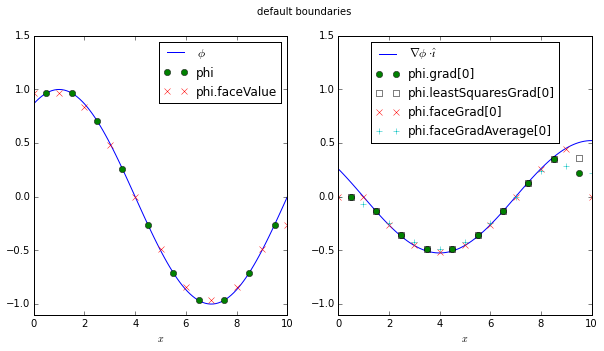

In [6]:
plotValueAndSlope(phi, title='default boundaries')

Here we see that, because $\phi_A = \phi_P$ at the boundaries, $\phi_f = \phi_P$ at the boundaries, too, i.e., boundary faces have the value of their sole neighboring cell.

As a result, `phi.faceGrad` is zero on the boundary faces, as intended, and all other calculated gradients are "pulled" toward zero near the boundaries.

# with constraints

In [7]:
phi.constrain(fn(mesh.faceCenters[0]), where=mesh.facesLeft)
phi.faceGrad.constrain(fn_x(mesh.faceCenters[0]), where=mesh.facesRight)

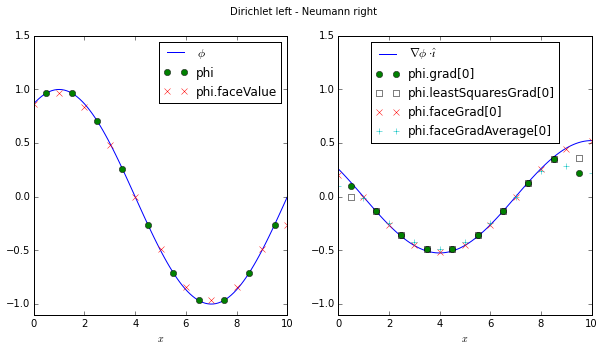

In [8]:
plotValueAndSlope(phi, title='Dirichlet left - Neumann right')

In this case, we see that the left boundary value of `phi.faceValue` properly reflects the applied constraint, but at the right, $\phi_f = \phi_P$ as though there were no constraint. 

`phi.faceGrad` has the Neumann condition applied exactly at the right and it "sees" the Dirichlet condition on the left.

`phi.grad` "sees" the Dirichlet condition, but not the Neumann condition.

`phi.leastSquaresGrad` doesn't "see" either boundary condition.

`phi.faceGrad` naturally "sees" constraints on `phi.faceValue`, but the reverse is not true. With appropriate upwinding, it should be possible (and desirable) to make `phi.faceValue` depend on constraints to `phi.faceGrad`, but there is a danger of circular definitions and the calculation would be comparatively expensive.

# upwinding

As an illustration of how to approach upwinding, we can approximate the value at a face from its neighboring cell value and applied gradient as
$$\phi_f \approx \phi_P + \hat{n}_f\cdot\nabla_f\phi\,d_{fP}$$

In [48]:
R = mesh.facesRight
n = mesh.faceNormals
dfP = mesh._cellDistances[R.value][0]
cellsNearRight = (R * n).divergence
phi.constrain(phi[(cellsNearRight != 0).value].value 
              + (phi.faceGrad.dot(n) * dfP)[R.value].value, 
              where=R)

This is ugly, and not dynamic, but it does illustrate that we get the "right" value at the boundary and an improvement in $\nabla_P\phi$, too:

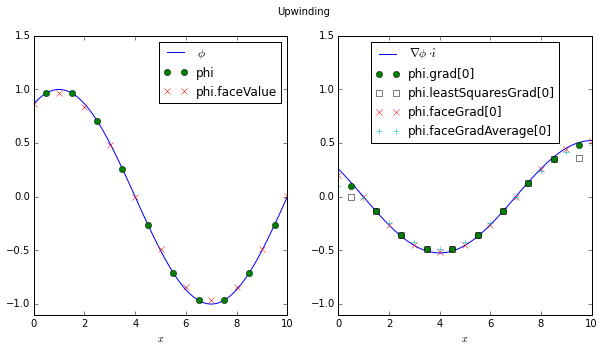

In [49]:
plotValueAndSlope(phi, title='Upwinding')